In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Part 1

In [ ]:
data = pd.read_csv('../Arrest_Data_from_2010_to_Present.csv')

## Question 1
How many bookings of arrestees were made in 2018?

In [29]:
import datetime as dt

let's first convert the times to datetime format

In [20]:
data["Arrest Date"] = pd.to_datetime(data["Arrest Date"])

let's get all the arrests made in 2018

In [36]:
data_2018 = data[data['Arrest Date'].dt.year==2018]

In [38]:
len(data_2018)

104277

## Question 2 
How many bookings of arrestees were made in the area with the most arrests in 2018?

--- 

let's find out which area had most arrests

In [42]:
from collections import Counter

In [44]:
areas_2018 = Counter(data_2018['Area Name'])

In [45]:
areas_2018.most_common(10)

[('Central', 10951),
 ('Hollywood', 9715),
 ('Rampart', 7345),
 ('Pacific', 6778),
 ('77th Street', 6259),
 ('Van Nuys', 6193),
 ('Southwest', 5927),
 ('Newton', 5427),
 ('N Hollywood', 4947),
 ('Mission', 4357)]

## Question 3
What is the 95% quantile of the age of the arrestee in 2018? Only consider the following charge groups for your analysis:

    Vehicle Theft
    Robbery
    Burglary
    Receive Stolen Property



In [63]:
list_of_crimes = ['Vehicle Theft', 'Robbery',
                'Burglary', 'Receive Stolen Property'] 

In [66]:
data_2018_crimes = data_2018.query("`Charge Group Description` in @list_of_crimes")

In [167]:
data_2018_crimes['Age'].quantile(0.95)

52.0

## Question 4 

There are differences between the average age of an arrestee for the various charge groups. Are these differences statistically significant? For this question, calculate the Z-score of the average age for each charge group. Report the largest absolute value among the calculated Z-scores.

    Only consider data for 2018
    Do not consider "Pre-Delinquency" and "Non-Criminal Detention" as these charge groups are reserved for minors
    Exclude any arrests where the charge group description is not known



In [76]:
from scipy.stats import zscore

In [108]:
charge_groups = [i for i in data_2018['Charge Group Description'].unique() if i not in ["Pre-Delinquency", "Non-Criminal Detention", np.nan]]

In [136]:
all_ages = data_2018.query("`Charge Group Description` in @charge_groups")['Age']

let's check the z scores of the means of each group for the complete 2018 data  (excluding charge groups mentioned in text)

In [137]:
zscores = []
for i in range(len(charge_groups)):
    vals= np.mean(data_2018.query("`Charge Group Description`==@charge_groups[@i]")['Age'].values)
    zscores.append(np.abs((vals-np.mean(all_ages))/np.std(all_ages)))

In [169]:
max(zscores)

0.6934321879024

this shows there's no significant diff. in age across fellonies, but it's an odd way of measuring it IMO. 

## Question 5

Felony arrest incidents have been dropping over the years. Using a trend line (linear estimation) for the data from 2010 and 2018 (inclusive), what is the projected number of felony arrests in 2019? Round to the nearest integer. Note, the data set includes arrests for misdemeanor, felonies, etc.

In [141]:
data_pre209 = data[data['Arrest Date'].dt.year<2019]
felonies_pre19 = data_pre209.query("`Arrest Type Code`=='F'")

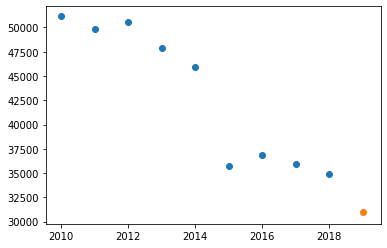

In [161]:
plt.scatter(np.arange(2010,2019), [sum(felonies_pre19['Arrest Date'].dt.year==ye) for ye in np.arange(2010,2019)])
plt.scatter(2019,31037.81)

In [157]:
x= np.arange(2010,2019)
y= [sum(felonies_pre19['Arrest Date'].dt.year==ye) for ye in np.arange(2010,2019)]
np.polyfit(x,y,1)

array([-2.43395000e+03,  4.94518286e+06])

let's predict the value for 2019

In [160]:
(2019*-2.43395000e+03)+4.94518286e+06

31037.81000000052

## Question 6

How many arrest incidents were made per kilometer on Pico Boulevard during 2018? 
For this question, we will need to estimate the length of Pico Boulevard, which mostly stretches from east to west. To estimate the length of Pico Boulevard:

    Consider all location data which the listed address mentions "Pico".
    

In [191]:
pico_add = data_2018.iloc[np.where(['PICO' in i for i in data_2018['Address'].values])[0]]

Remove outliers by filtering out locations where either the latitude or longitude is 2 standard deviations beyond the mean of the subset of identified points.

In [202]:
from ast import literal_eval as make_tuple

In [205]:
longlats = [make_tuple(i) for i in pico_add['Location'].values]

In [242]:
lat_min = np.mean([i[0] for i in longlats])-2*np.std([i[0] for i in longlats]) 
lat_max = np.mean([i[0] for i in longlats])+2*np.std([i[0] for i in longlats]) 

long_min = np.mean([i[1] for i in longlats])-2*np.std([i[1] for i in longlats]) 
long_max = np.mean([i[1] for i in longlats])+2*np.std([i[1] for i in longlats]) 

In [228]:
clean_longlats = np.array(longlats)[np.where([(lat_min<i[0]<lat_max) and (long_min<i[1]<long_max) for i in longlats])[0]]

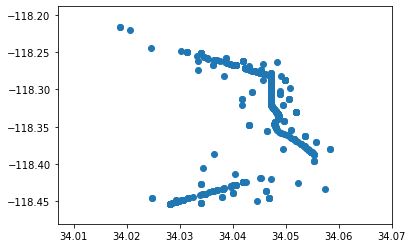

In [243]:
clean_lats = [i[0] for i in clean_longlats]
clean_longs = [i[1] for i in clean_longlats]
plt.scatter(clean_lats,clean_longs)

To estimate the length, calculate the distance from the most western and eastern coordinate points. Use the spherical Earth projected to a plane equation for calculating distances.


In [245]:
import math

In [252]:
def geographical_distance (latitudeA, longitudeA, latitudeB, longitudeB):
    # Degrees to radians
    delta_latitude  = math.radians(latitudeB  - latitudeA)
    delta_longitude = math.radians(longitudeB - longitudeA)
    mean_latitude   = math.radians((latitudeA + latitudeB) / 2.0 )
 
    R = 6371 # Km
    # Spherical Earth projected to a plane  
    dist = R*math.sqrt(math.pow(delta_latitude,2)+math.pow(math.cos(mean_latitude) *delta_longitude, 2) )
    return dist

In [253]:
pico_kms = geographical_distance(clean_longlats[np.argmax(clean_lats)][0],clean_longlats[np.argmax(clean_lats)][1],
                      clean_longlats[np.argmin(clean_lats)][0],clean_longlats[np.argmin(clean_lats)][1])


Once you have estimated the length of Pico Boulevard, you can proceed to report the number of arrest incidents per kilometer on Pico Boulevard in 2018.

In [254]:
len(clean_longlats)/pico_kms

38.444910749969615

## Question 7
How many arrest incidents occurred within 2 km from the Bradbury Building in 2018? Use (34.050536, -118.247861) for the coordinates of the Bradbury Building.

For simplicity, please use the spherical Earth projected to a plane equation for calculating distances. Use the radius of the Earth as 6371 km. 

Note, some arrest records are missing location data and the location is listed as (0, 0). These records should not factor in your calculation.

In [265]:
data_2018_latlong = [make_tuple(i) for i in data_2018['Location'].values]
data_2018_latlong = [i for i in data_2018_latlong if i!= (0,0)]

In [266]:
[0]

(34.0949, -118.3109)

In [281]:
bradbury_incidents = [geographical_distance(34.050536, -118.247861, i[0], i[1])<=2 for i in data_2018_latlong]

In [282]:
sum(bradbury_incidents)

11461

let's do a quick visual check

In [277]:
bradbury_pos = np.array(data_2018_latlong)[np.where(bradbury_incidents)[0]]

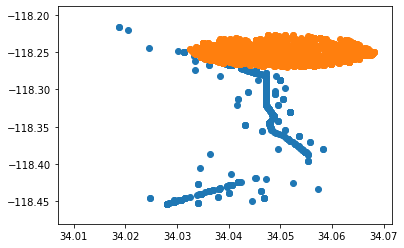

In [280]:
plt.scatter(clean_lats,clean_longs)
plt.scatter([i[0] for i in bradbury_pos], [i[1] for i in bradbury_pos])

## Question 8

Some types of arrest incidents in certain areas occur at a highly disproportionate rate compared to their frequency city-wide. For example, let's say that the rate of larceny arrests (charge group code 6) is 1% in Devonshire (area ID 17). This rate may appear low but what if larceny arrests constitute 0.1 % city-wide? The ratio between these two probabilities is 10 and we can say that larceny occurs unusually often in Devonshire (Note, these numbers were made up for illustration purposes). Calculate this ratio for all charge group code and area ID pairs. You can view this ratio as the ratio of the conditional probability of an arrest incident of a charge group code given that it occurred in an area ID to the unconditional probability of the arrest incident of a charge group. Report the average of the top 5 of the calculated ratio.

    Consider all records prior to January 1, 2019.
    Some arrest incidents don't have a charge group code. 
    These records should not be considered in your analysis.
    Arrest incidents for charge group code 99 should not be considered in your analysis.



In [284]:
data_pre19 = data[data['Arrest Date'].dt.year<2019]
charges_not_nan = np.where([not np.isnan(i) and i!=99 for i in data_pre19['Charge Group Code'].values ])[0]
data_pre19_clean = data_pre19.iloc[charges_not_nan]

In [311]:
area_codes = np.unique(data_pre19_clean['Area ID'].values)

In [328]:
dlist = [Counter(data_pre19_clean['Charge Group Code'].values)]

for i in area_codes:
    dic = Counter(data_pre19_clean.query("`Area ID`==@i")['Charge Group Code'].values)
    dlist.append(dic)

In [329]:
# put frequency dicts into dataframe
df = pd.DataFrame(dlist)
# get ratios
df_ratios = (df.T / df.T.sum()).T

get the ratio over city wide frequencies

In [339]:
ratios = df_ratios.iloc[1:]/df_ratios.iloc[0]

let's get the top 5 values

In [347]:
np.mean(np.sort(np.ndarray.flatten(ratios.values))[::-1][:5])

3.515076379865202

### SCRIPT

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter

data = pd.read_csv('../Arrest_Data_from_2010_to_Present.csv')
data["Arrest Date"] = pd.to_datetime(data["Arrest Date"])

data_pre19 = data[data['Arrest Date'].dt.year<2019]
charges_not_nan = np.where([not np.isnan(i) and i!=99 for i in data_pre19['Charge Group Code'].values ])[0]
data_pre19_clean = data_pre19.iloc[charges_not_nan]

area_codes = np.unique(data_pre19_clean['Area ID'].values)

# let's initialise list with city wide frequencies of incident types 
dlist = [Counter(data_pre19_clean['Charge Group Code'].values)]

for i in area_codes:
    # get frequencies given area ID
    dic = Counter(data_pre19_clean.query("`Area ID`==@i")['Charge Group Code'].values)
    dlist.append(dic)
    
# put frequency dicts into dataframe
df = pd.DataFrame(dlist)
# get ratios
df_ratios = (df.T / df.T.sum()).T

# get the ratio over city wide frequencies
ratios = df_ratios.iloc[1:]/df_ratios.iloc[0]

# let's get the mean of the top 5 values
np.mean(np.sort(np.ndarray.flatten(ratios.values))[::-1][:5])
### result: 3.515076379865202

3.515076379865202

# Part 2

Consider a grid in d-dimensional space. There are n grid lines in each dimension, spaced one unit apart. We will consider a walk of m steps from grid intersection to grid intersection. Each step will be a single unit movement in any one of the dimensions, such that it says on the grid. We wish to look at the number of possible paths from a particular starting location on this grid.

In [2]:
import functools
import networkx as nx

In [3]:
@functools.lru_cache(maxsize=None)
def findPaths(G,u,n):
    if n==0:
        return [[u]]
    paths = [[u]+path for neighbor in G.neighbors(u) for path in findPaths(G,neighbor,n-1) ]
    return paths

first, test case:

In [4]:
d = 3
n = 4
init = (0,0,0)
walk_length = 2

G = nx.grid_graph(dim=list(np.array(np.ones(d)*n,int)))

In [5]:
len(findPaths(G,init,walk_length))

12

let's compare this with the adjacency matrix method

In [6]:
sum(np.array((nx.adjacency_matrix(G).todense()**walk_length))[0])

12

In [9]:
init = (0, 0, 0, 0)
walk_length = 10

d = 4
n = 10
G = nx.grid_graph(dim=list(np.array(np.ones(d)*n,int)))

let's get the sparse matrix

In [10]:
sparse = nx.adjacency_matrix(G)
sparse_n = sparse**walk_length

In [11]:
sum(np.array(sparse_n[0].todense())[0])

44569724

Consider the count of valid walks associated with each possible starting position. What is the ratio of the highest count of valid walks to smallest count of valid walks?

In [12]:
totalnodes = 10000

In [13]:
all_init_walks = [sum(np.array(sparse_n[i].todense())[0]) for i in range(totalnodes)]

In [14]:
max(all_init_walks)/ min(all_init_walks)

23.81209118548726

Consider the count of valid walks associated with each possible starting position. What is the ratio of the standard deviation of the number of valid walks to the mean of the number of valid walks?

In [15]:
np.std(all_init_walks)/np.mean(all_init_walks)

0.5106573744484553

Now, let's consider the case where d=8, n=12, and m=12.

How many valid walks start from one of the corners?

In [ ]:
init = (0, 0, 0, 0, 0, 0, 0, 0)
walk_length = 12
3
d = 8
n = 12
# G = nx.grid_graph(dim=list(np.array(np.ones(d)*n,int)))

can we create the adjacency directly?